In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import seaborn as sns
import tensorflow as tf
tf.__version__

'2.0.0-beta0'

In [4]:
from environment import TradingEnvironment
from market_instance import new_market, make_investors

### Configuration for the synthetic market

In [5]:
config = {
    'num_investors': 10,
    'num_rounds_per_day': 3
}

### Our own portfolio

In [6]:
holdings = {
    'cash': 100000.00, 
    'TSLA': 300, 
    'AAPL': 200, 
    'MSFT': 400}

### Create the RL Environment

In [12]:
market = new_market()
environment = TradingEnvironment(config, holdings, market, 0.002)

## The market in action

In [13]:
for _ in range(720):
    market.open()
    daily = environment.let_others_trade()
    market.close()

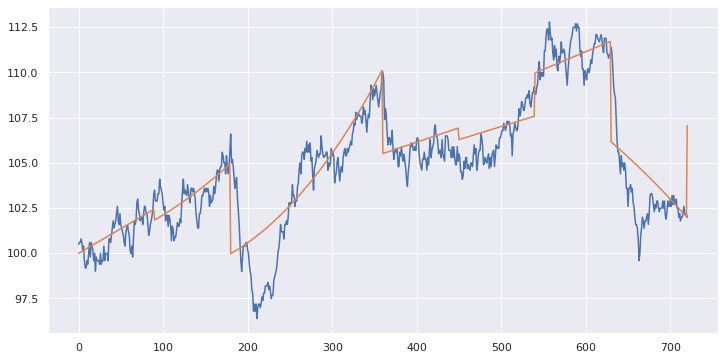

In [14]:
def plot(ticker):
    sns.set(rc={'figure.figsize':(12.0,6.0)})
    h = market.history_for(ticker)
    s = market.stocks[ticker]
    p_open, p_close, p_high, p_low = np.transpose(h)
    t = np.array(range(len(p_open)))
    sns.lineplot(t, p_open);
    sns.lineplot(t, [s.psi(tt) for tt in t]);
plot('AAPL')

## Perform an Action = Re-Balance

In [10]:
target_weights = np.array([.1, .3, .4, .2])

In [11]:
investor = environment.investor
print(investor, environment.total_wealth())
environment.act(target_weights)
print(investor, environment.total_wealth())

WB (cash: 100000.0, {'TSLA': 300, 'AAPL': 200, 'MSFT': 400}) 252268.2
WB (cash: 50348.68, {'TSLA': 704, 'AAPL': 226, 'MSFT': 348}) 252462.104


In [12]:
# slightly off-target because of integer stock counts and the trading costs.
environment.normalized_holdings()

array([0.09904135, 0.29691682, 0.40461119, 0.19943064])

### The ANN-based Trader Model

In [13]:
N_LSTM_NEURONS = 128
N_STOCKS = len(holdings)-1
BATCH_SIZE = 128
N_STEPS = 20                  # history length for the LSTM
N_OUT = N_STOCKS + 1          # stocks and cash
# current log returns, positions' weights, cash weight
N_FEATURES = N_STOCKS * 2 + 1

In [14]:
from models import LSTM_TraderModel

In [15]:
lstm_model = LSTM_TraderModel(
    n_neurons=N_LSTM_NEURONS, 
    n_steps=N_STEPS,
    n_features=N_FEATURES,
    n_out=N_OUT)

x = np.random.random(
    [BATCH_SIZE, N_STEPS, N_FEATURES]).astype(np.float32)

y = lstm_model(x) # initialize the model
test_portfolio = lstm_model.portfolio(x)
lstm_model.summary()

Model: "lstm__trader_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  multiple                  69632     
_________________________________________________________________
dense (Dense)                multiple                  516       
Total params: 70,148
Trainable params: 70,148
Non-trainable params: 0
_________________________________________________________________


In [16]:
x = np.random.random(
    [1, 9, N_FEATURES]).astype(np.float32)
x

array([[[0.2338565 , 0.19052702, 0.12293639, 0.47924796, 0.855093  ,
         0.97873974, 0.30469254],
        [0.24563965, 0.11924134, 0.8609986 , 0.4730563 , 0.41284195,
         0.7936848 , 0.37569106],
        [0.19127066, 0.68101776, 0.8025869 , 0.95876694, 0.46937856,
         0.09880988, 0.95810413],
        [0.4854254 , 0.71326023, 0.48416075, 0.67048424, 0.7445696 ,
         0.9730254 , 0.16871436],
        [0.10361053, 0.60678387, 0.14091247, 0.31150445, 0.97037005,
         0.32043865, 0.6711941 ],
        [0.90431136, 0.33188   , 0.91690505, 0.04296798, 0.15254396,
         0.33285257, 0.10211508],
        [0.5743075 , 0.10396957, 0.3168866 , 0.4550849 , 0.8684875 ,
         0.53142715, 0.9813407 ],
        [0.42872968, 0.88142014, 0.691578  , 0.22909991, 0.44112033,
         0.0931378 , 0.16278008],
        [0.33813176, 0.46783084, 0.68538946, 0.7761062 , 0.09483359,
         0.33257926, 0.72779405]]], dtype=float32)

In [17]:
weights = lstm_model.get_weights()

In [18]:
lstm_model.portfolio(x)

<tf.Tensor: id=472, shape=(1, 4), dtype=float32, numpy=array([[0.2726496 , 0.26056814, 0.24916512, 0.21761711]], dtype=float32)>

### Observation And Reward
The observation consists of the normalized holdings and the normalized log returns of the traded assets with respect to the closing prices. 

In [19]:
obs, reward = environment.act([.2, .2, .3, .3])
print("Observations: 4x normalized holdings, 3x normalized log returns:")
print(obs)
print("Reward: %s" % reward)

Observations: 4x normalized holdings, 3x normalized log returns:
[ 0.20024021  0.19793327  0.30260978  0.29921674  0.17309329 -0.48442982
  0.34247689]
Reward: 0.00029124486577108874
